In [1]:
#Imports
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from time import time
import datetime
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# Read in data
df = pd.read_csv('./data/daily.csv')
# Show information to verify clean data set
print('----------Data Information----------\n')
print(df.info())
print('\n----------Missing Values----------\n', )
print(df.isnull().sum())
print('\n----------Shape----------\n')
print(df.shape)

----------Data Information----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       3653 non-null   int64  
 1   date             3653 non-null   object 
 2   text             3653 non-null   object 
 3   price            3653 non-null   float64
 4   pct_change       3652 non-null   float64
 5   price_direction  3653 non-null   object 
 6   day_of_week      3653 non-null   int64  
 7   is_holiday       3653 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 228.4+ KB
None

----------Missing Values----------

Unnamed: 0         0
date               0
text               0
price              0
pct_change         1
price_direction    0
day_of_week        0
is_holiday         0
dtype: int64

----------Shape----------

(3653, 8)


In [4]:
# Drop 'first' in the price_direction column
df = df[df.price_direction != 'first']

In [5]:
# Initialize Vader Sentiment Intensity Analyzer
vader = SentimentIntensityAnalyzer()

In [6]:
# Create a new column called 'vader_text_sentiment' 
# and apply a lambda function that applies vader polarity scores to the all_text column
fab = lambda text: vader.polarity_scores(text)['compound']
df['vader_text_sentiment'] = df['text'].apply(fab)

In [7]:
# Create a new column called 'textblob_polarity' 
# and apply a lambda function that applies textblob_polarity scores to the all_text column
df['textblob_polarity'] = df['text'].map(lambda words: TextBlob(str(words)).polarity)

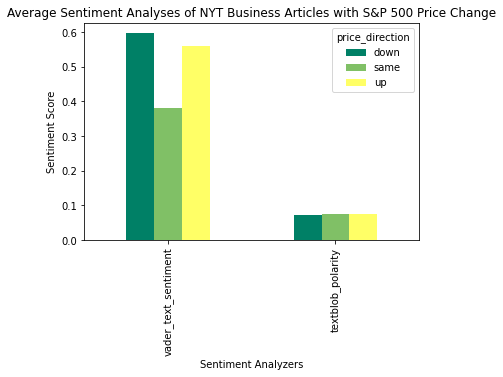

In [8]:
df.groupby('price_direction')['vader_text_sentiment','textblob_polarity'].mean().T.plot(kind='bar', stacked=False, colormap='summer')
plt.title('Average Sentiment Analyses of NYT Business Articles with S&P 500 Price Change')
plt.xlabel('Sentiment Analyzers')
plt.ylabel('Sentiment Score');

# https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [9]:
# Get rid of all remaining nulls
df.dropna(inplace=True)

In [10]:
# Convert price_change values to integers
df['price_direction'] = df['price_direction'].map(lambda x: 0 if x == 'down' else (x))
df['price_direction'] = df['price_direction'].map(lambda x: 1 if x == 'up' else (x))
df['price_direction'] = df['price_direction'].map(lambda x: 2 if x == 'same' else (x))

In [11]:
df_sent = df.drop(columns=['Unnamed: 0','price','is_holiday','pct_change','day_of_week'])

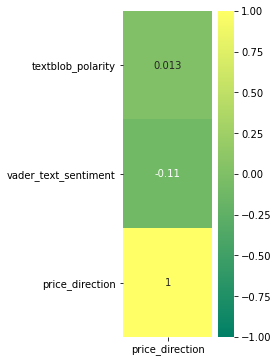

In [12]:
plt.figure(figsize = (2, 6))
sns.heatmap(df_sent.corr()[['price_direction']].sort_values(by ='price_direction', key = np.abs), 
            vmin = -1, vmax = 1, cmap = 'summer', annot=True);

##### Linear Regression Models

##### Vader as our X

In [13]:
# Assemble X and y variables
X = df['vader_text_sentiment']
y = df['pct_change']

# Convert to numpy array
X = np.array(X)
y = np.array(y)

# Reshape
X = X.reshape(-1,1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
shuffle=False, random_state = 42)

# Scale data 
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# Instantiate the model
lr = LinearRegression()

# check sizes of train and test sets 
Xs_train.shape,Xs_test.shape

((2921, 1), (731, 1))

In [14]:
# Instantiate and fit linreg model 
lr = LinearRegression().fit(Xs_train,y_train)

In [15]:
def get_metrics(model,X_train=Xs_train,X_test=Xs_test):
    'MSE on unscaled data'
    # get predictions 
    train_preds= model.predict(X_train)
    test_preds= model.predict(X_test)
    
    train_mse = mean_squared_error(y_train,train_preds)
    test_mse= mean_squared_error(y_test,test_preds)
    
    print(f'Training MSE: {round((train_mse),4)}')
    print(f'Testing MSE: {round((test_mse),4)}')
    print(f'Test - Train(overage): {round((test_mse)-(train_mse),4)}')
    print(f'R2: {round(metrics.r2_score(y_test, test_preds),4)}')
    return

In [16]:
# metric scores
get_metrics(lr)

Training MSE: 0.0001
Testing MSE: 0.0002
Test - Train(overage): 0.0001
R2: -0.0032


The models MSE is just slightly worse than the baseline MSE.

~.0032% of the variability in price_direction can be explained by the vader_text_sentiment scores

##### Textblob as our X

In [17]:
# Assemble X and y variables
Xtb = df['textblob_polarity']
y = df['price_direction']

# Convert to numpy array
Xtb = np.array(Xtb)
y = np.array(y)

# Reshape
Xtb = Xtb.reshape(-1,1)

# Train test split
Xtb_train, Xtb_test, y_train, y_test = train_test_split(Xtb, y, test_size=0.2,
shuffle=False, random_state = 42)

# Scale data 
ss = StandardScaler()
Xtbs_train = ss.fit_transform(Xtb_train)
Xtbs_test = ss.transform(Xtb_test)

# Instantiate the model
lr = LinearRegression()

# check sizes of train and test sets 
Xtbs_train.shape,Xtbs_test.shape

((2921, 1), (731, 1))

In [18]:
# Instantiate and fit linreg model 
lr = LinearRegression().fit(Xtbs_train,y_train)

In [19]:
def get_metrics(model,Xtb_train=Xtbs_train,Xtb_test=Xtbs_test):
    'MSE on unscaled data'
    # get predictions 
    train_preds= model.predict(Xtb_train)
    test_preds= model.predict(Xtb_test)
    
    train_mse = mean_squared_error(y_train,train_preds)
    test_mse= mean_squared_error(y_test,test_preds)
    
    print(f'Training MSE: {round((train_mse),4)}')
    print(f'Testing MSE: {round((test_mse),4)}')
    print(f'Test - Train(overage): {round((test_mse)-(train_mse),4)}')
    print(f'R2: {round(metrics.r2_score(y_test, test_preds),4)}')
    return

In [20]:
# metric scores
get_metrics(lr)

Training MSE: 0.6242
Testing MSE: 0.6006
Test - Train(overage): -0.0236
R2: -0.0094


The models MSE is 2.42% better than the baseline MSE.

~.009% of the variability in price_direction can be explained by the textblob_polarity      sentiment scores

##### Regression Pipeline

In [21]:
#Perform Scaling
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Splitting the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.2, random_state=42)

In [22]:
# Pipeline of regression models to run
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]
# https://machinelearninghd.com/gridsearchcv-hyperparameter-tuning-sckit-learn-regression-classification/

In [23]:
# Function to score regression models
head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.001s
	Prediction time: 0.001s
	Explained variance: -0.11473649567501432
	Mean absolute error: 0.6807113543091655
	R2 score: -0.11646574474823179

GradientBoostingRegressor()
	Training time: 0.083s
	Prediction time: 0.001s
	Explained variance: 0.08239168644649497
	Mean absolute error: 0.6436739196397184
	R2 score: 0.08135056765379467

KNeighborsRegressor()
	Training time: 0.001s
	Prediction time: 0.001s
	Explained variance: -0.11473649567501432
	Mean absolute error: 0.6807113543091655
	R2 score: -0.11646574474823179

ExtraTreesRegressor()
	Training time: 0.121s
	Prediction time: 0.012s
	Explained variance: -0.2225066096210535
	Mean absolute error: 0.6778029035052835
	R2 score: -0.2244472086279763

RandomForestRegressor()
	Training time: 0.191s
	Prediction time: 0.011s
	Explained variance: -0.14270568219427382
	Mean absolute error: 0.679241671595227
	R2 score: -0.14423495435885259

DecisionTreeRegressor()
	Training time: 0.002s
	Prediction time: 0.

Based on the R2 score, the top three performers are:

**ExtraTreesRegressor, DecisionTreeRegressor and RandomForestRegressor** so we will look at them closer by running gridsearch to optimize the scores

In [24]:
# ExtraTreeRegressor parameters
parameters = {'criterion' : ['mse', 'mae'],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

In [25]:
# initiate GridSearch to find best params and estimators
grid = GridSearchCV(ExtraTreesRegressor(),parameters)
model = grid.fit(X_sc,y)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'criterion': 'mse', 'max_features': 'auto'} 

ExtraTreesRegressor() 



<AxesSubplot:ylabel='Density'>

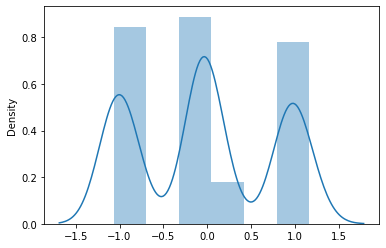

In [26]:
sns.distplot(y_pred-y_test)

In [27]:
# Create new data frame to view results - ranked in order of best scores
etr = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
etr.shape

(6, 14)

In [28]:
etr.T

rank_test_score,1,2,3,4,5,6
mean_fit_time,0.115962,0.111642,0.111685,3.633883,3.646859,3.643156
std_fit_time,0.00629,0.002471,0.002532,0.019909,0.036019,0.044036
mean_score_time,0.01171,0.011472,0.011401,0.012251,0.012388,0.012398
std_score_time,0.000476,0.000389,0.000352,0.0004,0.000473,0.0002
param_criterion,mse,mse,mse,mae,mae,mae
param_max_features,auto,sqrt,log2,auto,sqrt,log2
params,"{'criterion': 'mse', 'max_features': 'auto'}","{'criterion': 'mse', 'max_features': 'sqrt'}","{'criterion': 'mse', 'max_features': 'log2'}","{'criterion': 'mae', 'max_features': 'auto'}","{'criterion': 'mae', 'max_features': 'sqrt'}","{'criterion': 'mae', 'max_features': 'log2'}"
split0_test_score,-0.422934,-0.426249,-0.42072,-0.507264,-0.51263,-0.50497
split1_test_score,0.03238,0.031023,0.029733,-0.147833,-0.149222,-0.153992
split2_test_score,-0.097543,-0.099605,-0.101361,-0.263238,-0.258068,-0.263406


In [29]:
# DecisionTreeRegressor parameters
dt_parameters = {'criterion' : ['mse','friedman_mse','poisson'],
              'max_features' : ['auto', 'sqrt', 'log2'],
                               'splitter'   : ['best', 'random']
             }

In [30]:
# initiate GridSearch to find best params and estimators
grid = GridSearchCV(DecisionTreeRegressor(),parameters)
model = grid.fit(X_sc,y)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'criterion': 'mse', 'max_features': 'auto'} 

DecisionTreeRegressor(max_features='auto') 



<AxesSubplot:ylabel='Density'>

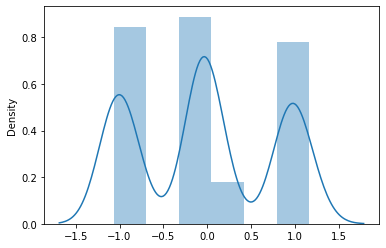

In [31]:
sns.distplot(y_pred-y_test)

In [32]:
# Create new data frame to view results - ranked in order of best scores
dt = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
dt.shape

(6, 14)

In [33]:
dt.T

rank_test_score,1,1,1,4,4,4
mean_fit_time,0.002535,0.002434,0.002421,0.465863,0.462554,0.464701
std_fit_time,0.000158,0.000184,0.000164,0.128316,0.128833,0.127616
mean_score_time,0.000321,0.000293,0.000285,0.000583,0.000364,0.000512
std_score_time,0.000048,0.000069,0.000031,0.000049,0.000043,0.00014
param_criterion,mse,mse,mse,mae,mae,mae
param_max_features,auto,sqrt,log2,auto,sqrt,log2
params,"{'criterion': 'mse', 'max_features': 'auto'}","{'criterion': 'mse', 'max_features': 'sqrt'}","{'criterion': 'mse', 'max_features': 'log2'}","{'criterion': 'mae', 'max_features': 'auto'}","{'criterion': 'mae', 'max_features': 'sqrt'}","{'criterion': 'mae', 'max_features': 'log2'}"
split0_test_score,-0.535722,-0.535722,-0.535722,-0.616805,-0.616805,-0.616805
split1_test_score,-0.009227,-0.009227,-0.009227,-0.192009,-0.192009,-0.192009
split2_test_score,-0.155354,-0.155354,-0.155354,-0.308683,-0.308683,-0.308683


In [34]:
# RandomForestRegressor parameters
rf_parameters = {'criterion' : ['gini','entropy'],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

In [35]:
# initiate GridSearch to find best params and estimators
grid = GridSearchCV(RandomForestRegressor(),parameters)
model = grid.fit(X_sc,y)
print(model.best_params_,'\n')
print(model.best_estimator_,'\n')

{'criterion': 'mae', 'max_features': 'auto'} 

RandomForestRegressor(criterion='mae') 



<AxesSubplot:ylabel='Density'>

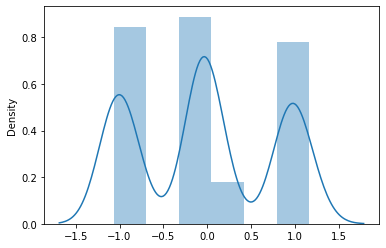

In [36]:
sns.distplot(y_pred-y_test)

In [37]:
# Create new data frame to view results - ranked in order of best scores
rf = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
rf.shape

(6, 14)

In [38]:
rf.T

rank_test_score,1,2,3,4,5,6
mean_fit_time,16.978418,17.508047,17.074836,0.1904,0.188192,0.188347
std_fit_time,4.712822,5.033813,5.346834,0.008184,0.007005,0.006515
mean_score_time,0.016422,0.016411,0.016094,0.011129,0.010633,0.010643
std_score_time,0.003185,0.002997,0.002972,0.000551,0.000542,0.000524
param_criterion,mae,mae,mae,mse,mse,mse
param_max_features,auto,sqrt,log2,log2,sqrt,auto
params,"{'criterion': 'mae', 'max_features': 'auto'}","{'criterion': 'mae', 'max_features': 'sqrt'}","{'criterion': 'mae', 'max_features': 'log2'}","{'criterion': 'mse', 'max_features': 'log2'}","{'criterion': 'mse', 'max_features': 'sqrt'}","{'criterion': 'mse', 'max_features': 'auto'}"
split0_test_score,-0.21811,-0.20662,-0.207751,-0.286464,-0.286435,-0.280184
split1_test_score,0.100922,0.103113,0.097311,0.077299,0.07236,0.076237
split2_test_score,-0.028667,-0.03028,-0.029469,-0.036729,-0.02809,-0.033309


**R2 score** is the amount of the variation in the output dependent attribute which is predictable from the input independent variable(s). A higher value of R2 is desirable as it indicates better results.

**Mean square error (MSE)** is the average of the square of the errors. The larger the number the larger the error. And since MSE is an error metric, i.e. the lower the better, negative MAE is the opposite: a value of -2.6 is better than a value of -3.0. Just remove the negative signs and treat them as MSE values

 **Mean Absolute Error (MAE)**. MAE is simply, as the name suggests, the mean of the absolute errors. The absolute error is the absolute value of the difference between the forecasted value and the actual value. MAE tells us how big of an error we can expect from the forecast on average.  And since MAE is an error metric, i.e. the lower the better, negative MAE is the opposite: a value of -2.6 is better than a value of -3.0. Just remove the negative signs and treat them as MAE values
 
**The mean_test_score** that sklearn returns is the mean calculated on all samples where each sample has the same weight. If you calculate the mean by taking the mean of the folds (splits), then you only get the same results if the folds are all of equal size.


 
 https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/#:~:text=Coefficient%20of%20determination%20also%20called%20as%20R%202,is%20predictable%20from%20the%20input%20independent%20variable%20%28s%29.
 https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/
 https://canworksmart.com/using-mean-absolute-error-forecast-accuracy/
 https://stackoverflow.com/questions/44947574/what-is-the-meaning-of-mean-test-score-in-cv-result